# Import libraries

In [8]:
# Import libraries
import pandas as pd
import plotly.express as px
from scipy.stats import zscore, ttest_ind
from sklearn.ensemble import IsolationForest
import os

# Get absolute path to the data file
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, "../.."))  # Go up two levels from notebooks/exploratory
data_path = os.path.join(project_root, "data", "raw", "loan_data.csv")

# Reusable Plotting Function
def save_plot(fig, filename):
    # Create reports/figures directory if it doesn't exist
    os.makedirs(os.path.join(project_root, "reports", "figures"), exist_ok=True)
    # Use absolute paths for saving
    fig.write_html(os.path.join(project_root, "reports", "figures", f"{filename}.html"))
    fig.write_image(os.path.join(project_root, "reports", "figures", f"{filename}.png"))
    fig.show()

# Load dataset
print(f"Loading data from: {data_path}")
df = pd.read_csv(data_path)


Loading data from: /Users/vaibhavsingh/loan_default_project/data/raw/loan_data.csv


# --- 0. Safe Column Access and Sampling ---

In [9]:

print("=== Sampling and Validation ===")
required_cols = ['Credit_Score', 'dtir1', 'loan_amount', 'LTV', 'Status', 'year', 'Region', 'loan_purpose', 'Gender']
try:
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing columns: {missing_cols}")
    if len(df) > 50000:
        df = df.sample(50000, random_state=42)
        print("Sampled 50,000 rows for performance")
except KeyError as e:
    print(e)
    raise

# --- 1. Data Overview ---
print("\n=== Data Overview ===")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())
print("\nData Types:\n", df.dtypes)
print("\nDefault Rate:\n", df['Status'].value_counts(normalize=True))


=== Sampling and Validation ===
Sampled 50,000 rows for performance

=== Data Overview ===
Shape: (50000, 34)

Columns: ['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status', 'dtir1']

First 5 rows:
             ID  year loan_limit             Gender approv_in_adv loan_type  \
24912    49802  2019         cf             Female         nopre     type2   
147068  171958  2019         cf  Sex Not Available           pre     type1   
123284  148174  2019         cf  Sex Not Available         nopre     type1   
53610    78500  2

# --- 2. Missing Values ---

In [10]:

print("\n=== Missing Values ===")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
print("Missing Values:\n", missing[missing > 0])
print("\nMissing Percentages:\n", missing_pct[missing_pct > 0])



=== Missing Values ===
Missing Values:
 loan_limit                    1127
approv_in_adv                  328
loan_purpose                    35
rate_of_interest             12154
Interest_rate_spread         12226
Upfront_charges              13237
term                            14
Neg_ammortization               38
property_value                5019
income                        2984
age                             72
submission_of_application       72
LTV                           5019
dtir1                         7966
dtype: int64

Missing Percentages:
 loan_limit                    2.254
approv_in_adv                 0.656
loan_purpose                  0.070
rate_of_interest             24.308
Interest_rate_spread         24.452
Upfront_charges              26.474
term                          0.028
Neg_ammortization             0.076
property_value               10.038
income                        5.968
age                           0.144
submission_of_application     0.144
L

# --- 3. Interactive Visualizations ---


=== Interactive Visualizations ===


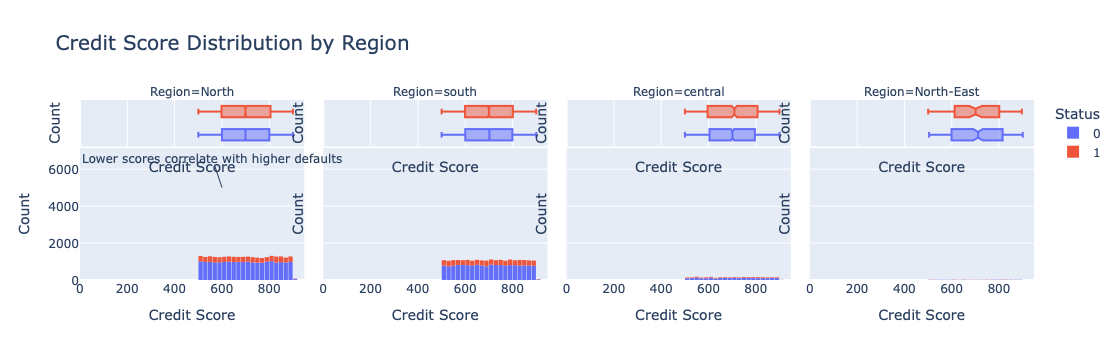

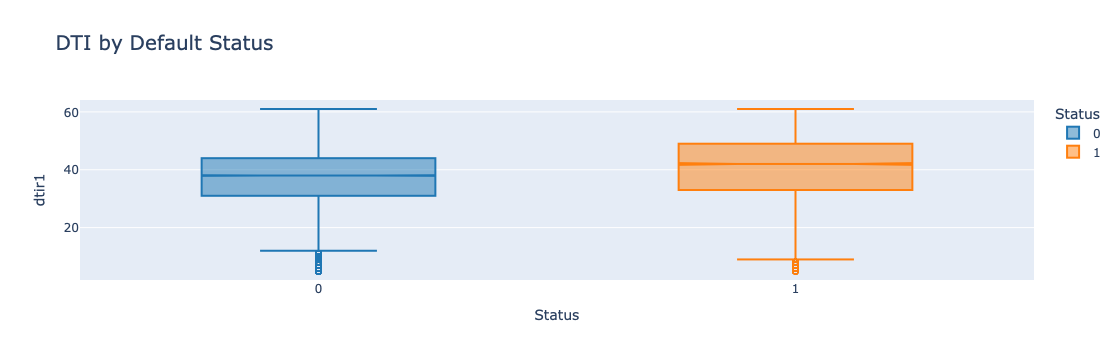

In [11]:

print("\n=== Interactive Visualizations ===")
# Credit Score Histogram with Facets
fig = px.histogram(df, x='Credit_Score', nbins=30, title='Credit Score Distribution by Region',
                   color='Status', facet_col='Region', marginal='box')
fig.update_layout(showlegend=True, bargap=0.1, title_font_size=20)
fig.update_xaxes(title_text='Credit Score', title_font_size=14)
fig.update_yaxes(title_text='Count', title_font_size=14)
fig.add_annotation(text='Lower scores correlate with higher defaults', x=600, y=5000, showarrow=True)
save_plot(fig, 'credit_score_dist')

# DTI Boxplot
fig_box = px.box(df, x='Status', y='dtir1', title='DTI by Default Status',
                 color='Status', points='suspectedoutliers', notched=True,
                 color_discrete_map={0: '#1f77b4', 1: '#ff7f0e'})
fig_box.update_layout(showlegend=True, title_font_size=20)
save_plot(fig_box, 'dti_by_default')


# --- 4. Statistical Test ---

In [12]:

print("\n=== T-Test: DTI by Default Status ===")
dti_default = df[df['Status'] == 1]['dtir1'].dropna()
dti_non_default = df[df['Status'] == 0]['dtir1'].dropna()
t_stat, p_value = ttest_ind(dti_default, dti_non_default)
print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")
print("Interpretation: Significant difference" if p_value < 0.05 else "No significant difference")



=== T-Test: DTI by Default Status ===
T-Statistic: 17.54, P-Value: 0.0000
Interpretation: Significant difference


# --- 5. Outlier and Anomaly Detection ---


=== Outlier Detection ===
Number of Outliers: 440

Outlier Summary:
             ID  loan_amount  Credit_Score  Status
94681   119571      1206500           700       1
120280  145170      1336500           536       1
31047    55937      1436500           861       1
100222  125112      1006500           552       1
71127    96017      1106500           781       0
Default Rate for Outliers: 45.91%


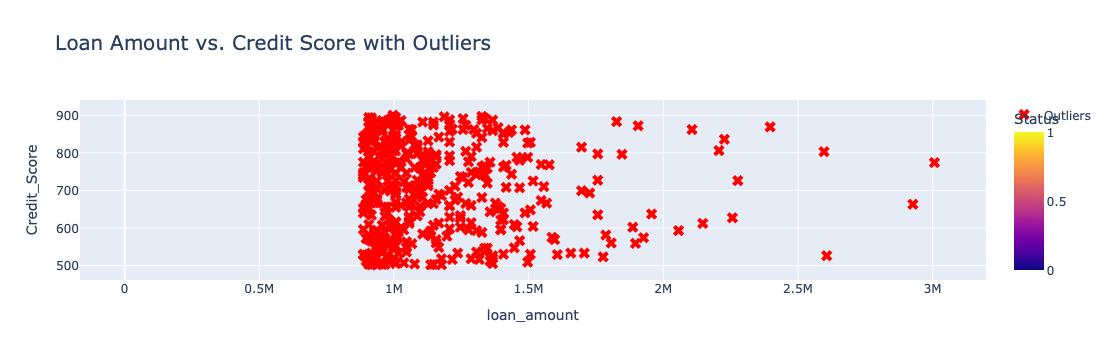


=== Anomaly Detection ===
Number of Anomalies: 2500
Anomaly Default Rate: 0.3312


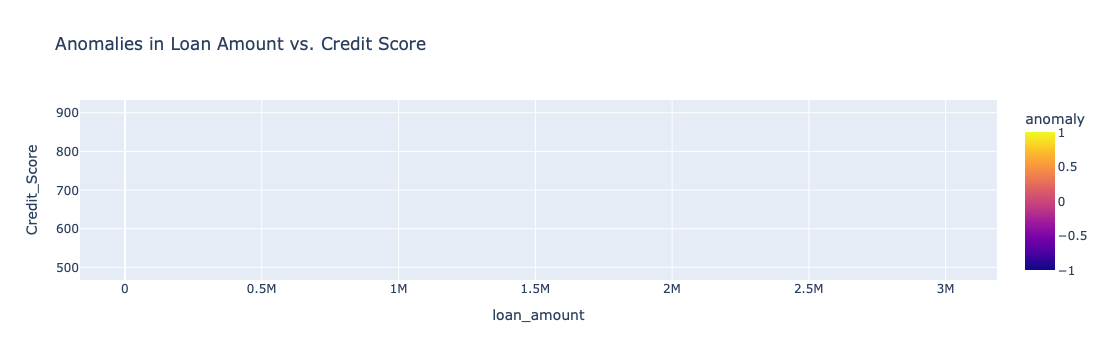

In [13]:
print("\n=== Outlier Detection ===")
df['loan_amount_z'] = zscore(df['loan_amount'])
outliers = df[df['loan_amount_z'].abs() > 3]
print("Number of Outliers:", len(outliers))
print("\nOutlier Summary:\n", outliers[['ID', 'loan_amount', 'Credit_Score', 'Status']].head())
outlier_default_rate = outliers['Status'].mean()
print(f"Default Rate for Outliers: {outlier_default_rate:.2%}")

# Scatter Plot for Outliers
fig = px.scatter(df, x='loan_amount', y='Credit_Score', color='Status',
                 title='Loan Amount vs. Credit Score with Outliers',
                 hover_data=['ID', 'dtir1'])
fig.add_scatter(x=outliers['loan_amount'], y=outliers['Credit_Score'],
                mode='markers', marker=dict(size=10, color='red', symbol='x'),
                name='Outliers')
fig.update_layout(showlegend=True, title_font_size=20)
save_plot(fig, 'outliers')

# Anomaly Detection
print("\n=== Anomaly Detection ===")
features = ['loan_amount', 'Credit_Score', 'dtir1']

# Create a clean copy for anomaly detection
df_clean = df[features].copy()
# Fill missing values with median of each column
for feature in features:
    df_clean[feature] = df_clean[feature].fillna(df_clean[feature].median())

# Now perform anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(df_clean)
anomalies = df[df['anomaly'] == -1]
print("Number of Anomalies:", len(anomalies))
print("Anomaly Default Rate:", anomalies['Status'].mean())
fig = px.scatter(df, x='loan_amount', y='Credit_Score', color='anomaly',
                 title='Anomalies in Loan Amount vs. Credit Score',
                 hover_data=['ID', 'dtir1'])
save_plot(fig, 'anomalies')

# --- 6. Temporal Analysis ---


=== Temporal Analysis ===
Yearly Default Rates:
    year   Status
0  2019  0.24452


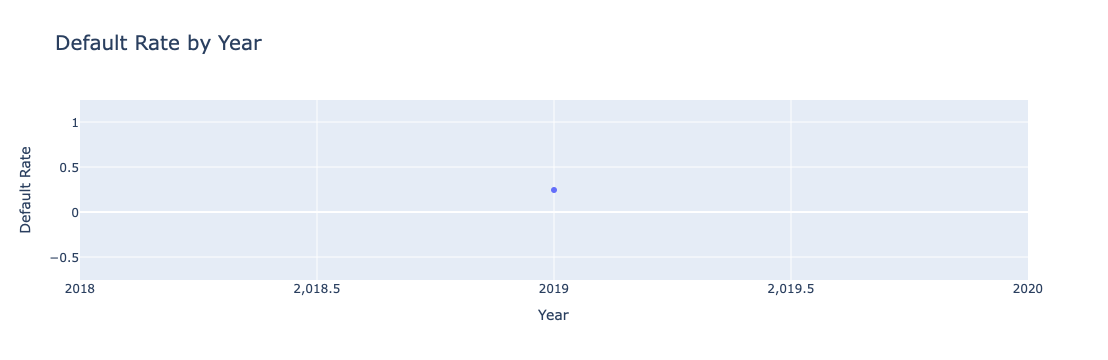

In [14]:

print("\n=== Temporal Analysis ===")
yearly_defaults = df.groupby('year')['Status'].mean().reset_index()
print("Yearly Default Rates:\n", yearly_defaults)
fig = px.line(yearly_defaults, x='year', y='Status', title='Default Rate by Year',
              markers=True, line_shape='spline')
fig.update_layout(showlegend=False, xaxis_title='Year', yaxis_title='Default Rate', title_font_size=20)
save_plot(fig, 'yearly_defaults')


# --- 7. Feature Interaction Heatmaps ---


=== Feature Interaction Heatmaps ===
Defaulted Loans Shape: (12226, 4)


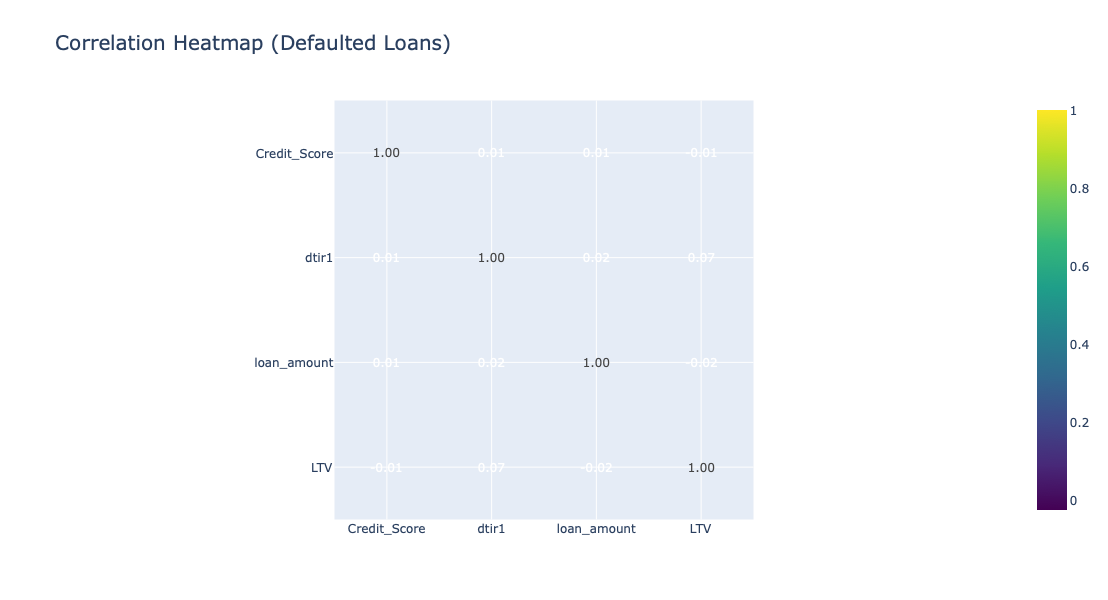

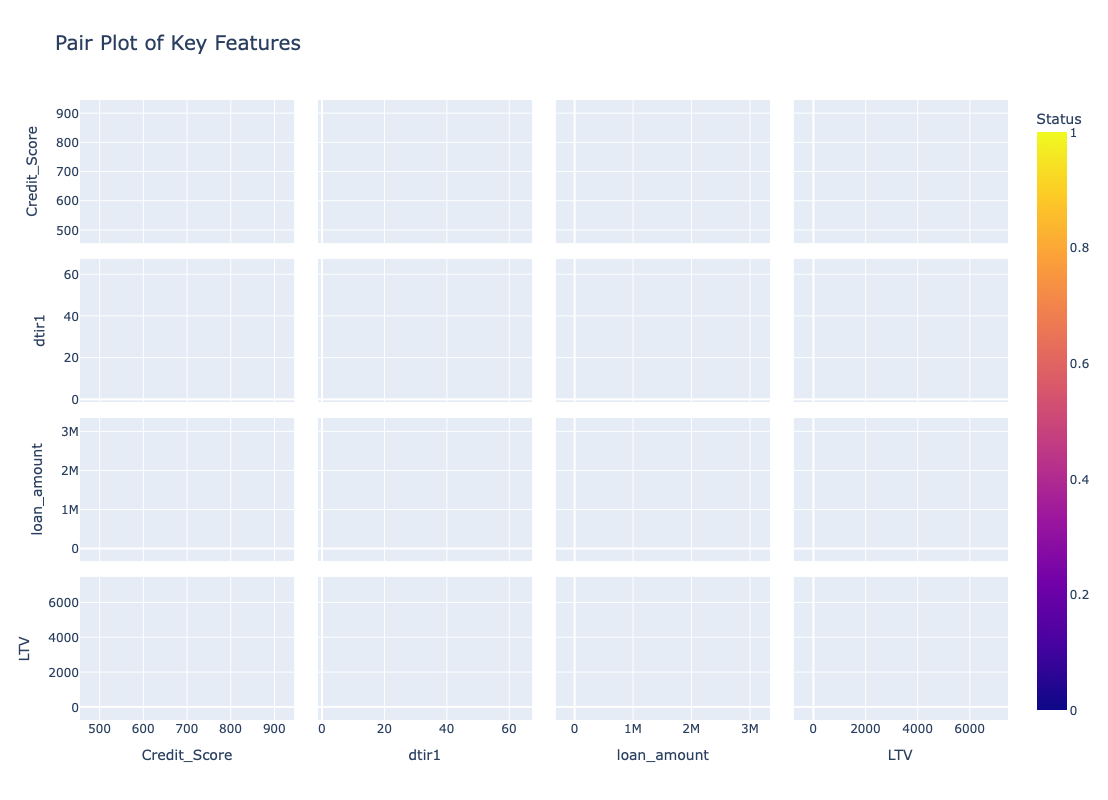

In [15]:

print("\n=== Feature Interaction Heatmaps ===")
defaulted = df[df['Status'] == 1][['Credit_Score', 'dtir1', 'loan_amount', 'LTV']]
print("Defaulted Loans Shape:", defaulted.shape)
corr_matrix = defaulted.corr()
fig = px.imshow(corr_matrix, title='Correlation Heatmap (Defaulted Loans)',
                color_continuous_scale='Viridis', text_auto='.2f')
fig.update_layout(width=600, height=600, title_font_size=20)
save_plot(fig, 'corr_defaulted')

# Pair Plot
fig = px.scatter_matrix(df, dimensions=['Credit_Score', 'dtir1', 'loan_amount', 'LTV'],
                        color='Status', title='Pair Plot of Key Features')
fig.update_layout(title_font_size=20, width=800, height=800)
save_plot(fig, 'pair_plot')


# --- 8. Categorical Analysis ---

In [16]:

print("\n=== Categorical Analysis ===")
purpose_defaults = df.groupby('loan_purpose')['Status'].mean().reset_index()
fig = px.bar(purpose_defaults, x='loan_purpose', y='Status',
             title='Default Rates by Loan Purpose', color='Status',
             text_auto='.2%')
fig.update_layout(title_font_size=20, xaxis_title='Loan Purpose', yaxis_title='Default Rate')
save_plot(fig, 'purpose_defaults')



=== Categorical Analysis ===


# --- 9. Fairness Analysis ---

In [17]:

print("\n=== Fairness Analysis ===")
gender_defaults = df.groupby('Gender')['Status'].mean()
print("Default Rates by Gender:\n", gender_defaults)
disparate_impact = gender_defaults['Male'] / gender_defaults['Female']
print(f"Disparate Impact (Male/Female): {disparate_impact:.2f}")
print("Note: Values far from 1.0 may indicate bias")



=== Fairness Analysis ===
Default Rates by Gender:
 Gender
Female               0.245539
Joint                0.189236
Male                 0.262073
Sex Not Available    0.284062
Name: Status, dtype: float64
Disparate Impact (Male/Female): 1.07
Note: Values far from 1.0 may indicate bias


# --- 10. Export Summary ---

In [19]:

print("\n=== Summary Statistics ===")
summary = df[['Credit_Score', 'dtir1', 'loan_amount', 'LTV']].describe()

# Use absolute path to save the summary
summary_path = os.path.join(project_root, 'reports', 'summary_stats.csv')
summary.to_csv(summary_path)
print(summary)


=== Summary Statistics ===
       Credit_Score         dtir1   loan_amount           LTV
count  50000.000000  42034.000000  5.000000e+04  44981.000000
mean     699.905620     37.779797  3.298206e+05     72.733882
std      115.753055     10.567833  1.827108e+05     43.853278
min      500.000000      5.000000  1.650000e+04      2.813745
25%      600.000000     31.000000  1.965000e+05     60.474860
50%      700.000000     39.000000  2.965000e+05     75.135870
75%      801.000000     45.000000  4.365000e+05     86.005435
max      900.000000     61.000000  3.006500e+06   6706.250000
